In [1]:
import numpy as np
import matplotlib.pyplot as plt

from SALib.sample import saltelli
from SALib.analyze import sobol
from math import *
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol

# Example 1: Sensitivity analysis in a range

Creating example inputs and outputs in a range


In [2]:
def parabola(x, a, b):
    """Return y = a + b*x**2."""
    return a + b*x**2
problem = {
    'num_vars': 2,
    'names': ['a', 'b'],
    'bounds': [[0, 1]]*2
}

# sample
param_values = saltelli.sample(problem, 2**6)

# evaluate
x = np.linspace(-1, 1, 100)
y = np.array([parabola(x, *params) for params in param_values])

# analyse
sobol_indices = [sobol.analyze(problem, Y) for Y in y.T]
S1s = np.array([s['S1'] for s in sobol_indices])


Visualising the example by plotting graphs

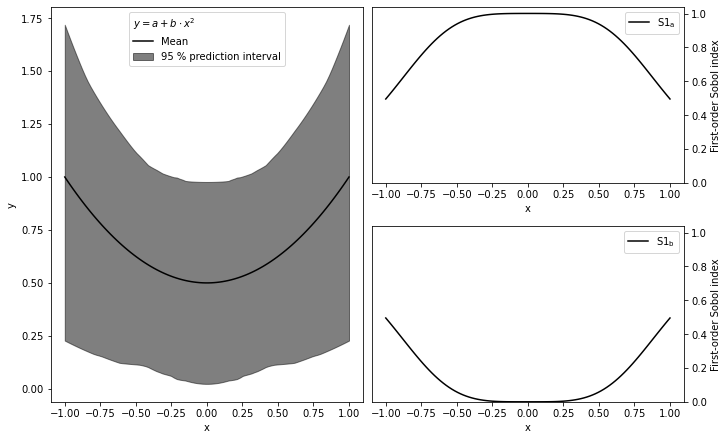

In [3]:
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1])

for i, ax in enumerate([ax1, ax2]):
    ax.plot(x, S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(problem["names"][i]),
            color='black')
    ax.set_xlabel("x")
    ax.set_ylabel("First-order Sobol index")

    ax.set_ylim(0, 1.04)

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    ax.legend(loc='upper right')

ax0.plot(x, np.mean(y, axis=0), label="Mean", color='black')

# in percent
prediction_interval = 95

ax0.fill_between(x,
                 np.percentile(y, 50 - prediction_interval/2., axis=0),
                 np.percentile(y, 50 + prediction_interval/2., axis=0),
                 alpha=0.5, color='black',
                 label=f"{prediction_interval} % prediction interval")

ax0.set_xlabel("x")
ax0.set_ylabel("y")
ax0.legend(title=r"$y=a+b\cdot x^2$",
           loc='upper center')._legend_box.align = "left"

plt.show()

First order, second order and total order sensitivity indices and minimum and maximum values of result

In [4]:

S1s = np.array([s['S1'] for s in sobol_indices])
S2s = np.array([s['S2'] for s in sobol_indices])
Sts = np.array([s['ST'] for s in sobol_indices])
print("First order indices")
print(S1s)
print("Second order indices")
print(S2s)
print("Total order indices")
print(Sts)

print("min:",min(map(min, y)))
print("max",max(map(max, y)))




First order indices
[[ 4.95265841e-01  4.95265841e-01]
 [ 5.15563712e-01  4.75005519e-01]
 [ 5.36223732e-01  4.54399826e-01]
 [ 5.57187473e-01  4.33507928e-01]
 [ 5.78389892e-01  4.12395501e-01]
 [ 5.99759734e-01  3.91134309e-01]
 [ 6.21220112e-01  3.69801603e-01]
 [ 6.42689282e-01  3.48479335e-01]
 [ 6.64081600e-01  3.27253178e-01]
 [ 6.85308651e-01  3.06211390e-01]
 [ 7.06280525e-01  2.85443525e-01]
 [ 7.26907217e-01  2.65039034e-01]
 [ 7.47100096e-01  2.45085790e-01]
 [ 7.66773414e-01  2.25668587e-01]
 [ 7.85845796e-01  2.06867658e-01]
 [ 8.04241659e-01  1.88757272e-01]
 [ 8.21892513e-01  1.71404450e-01]
 [ 8.38738101e-01  1.54867849e-01]
 [ 8.54727327e-01  1.39196857e-01]
 [ 8.69818959e-01  1.24430920e-01]
 [ 8.83982076e-01  1.10599120e-01]
 [ 8.97196254e-01  9.77200212e-02]
 [ 9.09451505e-01  8.58017597e-02]
 [ 9.20747964e-01  7.48423773e-02]
 [ 9.31095373e-01  6.48303676e-02]
 [ 9.40512369e-01  5.57454030e-02]
 [ 9.49025635e-01  4.75592075e-02]
 [ 9.56668928e-01  4.02365357e-02]


# Example 2: Sensitivity analysis in a range

In [15]:

def prob2(x,e1,h,l=25):
    L = l
    H = h
    Nx = 250
    Ny = 10
    mesh = RectangleMesh(Point(0., 0.), Point(L, H), Nx, Ny, "crossed")

    def eps(v):
        return sym(grad(v)  )

    E = Constant(e1)
    nu = Constant(.3)
    model = "plane_stress"

    mu = E/2/(1+nu)
    lmbda = E*nu/(1+nu)/(1-2*nu)
    if model == "plane_stress":
        lmbda = 2*mu*lmbda/(lmbda+2*mu)

    def sigma(v):
        return lmbda*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)

    rho_g = 1e-3
    f = Constant((0, -rho_g))

    V = VectorFunctionSpace(mesh, 'Lagrange', degree=2)
    du = TrialFunction(V)
    u_ = TestFunction(V)
    a = inner(sigma(du), eps(u_))*dx
    l = inner(f, u_)*dx
    def left(x, on_boundary):
        return near(x[0], 0.)

    bc = DirichletBC(V, Constant((0.,0.)), left)

    u = Function(V, name="Displacement")
    solve(a == l, u, bc)

    #plot(1e3*u, mode="displacement")
    # print("Maximal deflection:", -u(L,H/2.)[1])
    # print("Beam theory deflection:", float(3*rho_g*L**4/2/E/H**3))
    Vsig = TensorFunctionSpace(mesh, "DG", degree=0)
    sig = Function(Vsig, name="Stress")
    sig.assign(project(sigma(u), Vsig))
    #print("Stress at (0,H):", sig(0, H))

    # file_results = XDMFFile("elasticity_results.xdmf")
    # file_results.parameters["flush_output"] = True
    # file_results.parameters["functions_share_mesh"] = True
    # file_results.write(u, 0.)
    # file_results.write(sig, 0.)
    return -u(L,H/2.)[1]+(x-x)

In [6]:
def prob(x,e1,h):
    ans = list()
    for i in x:
        L = i
        H = h
        Nx = 250
        Ny = 10
        mesh = RectangleMesh(Point(0., 0.), Point(L, H), Nx, Ny, "crossed")

        def eps(v):
            return sym(grad(v))

        E = Constant(e1)
        nu = Constant(.3)
        model = "plane_stress"

        mu = E/2/(1+nu)
        lmbda = E*nu/(1+nu)/(1-2*nu)
        if model == "plane_stress":
            lmbda = 2*mu*lmbda/(lmbda+2*mu)

        def sigma(v):
            return lmbda*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)

        rho_g = 1e-3
        f = Constant((0, -rho_g))

        V = VectorFunctionSpace(mesh, 'Lagrange', degree=2)
        du = TrialFunction(V)
        u_ = TestFunction(V)
        a = inner(sigma(du), eps(u_))*dx
        l = inner(f, u_)*dx
        def left(x, on_boundary):
            return near(x[0], 0.)

        bc = DirichletBC(V, Constant((0.,0.)), left)

        u = Function(V, name="Displacement")
        solve(a == l, u, bc)

        #plot(1e3*u, mode="displacement")
        # print("Maximal deflection:", -u(L,H/2.)[1])
        # print("Beam theory deflection:", float(3*rho_g*L**4/2/E/H**3))
        Vsig = TensorFunctionSpace(mesh, "DG", degree=0)
        sig = Function(Vsig, name="Stress")
        sig.assign(project(sigma(u), Vsig))
        #print("Stress at (0,H):", sig(0, H))

        # file_results = XDMFFile("elasticity_results.xdmf")
        # file_results.parameters["flush_output"] = True
        # file_results.parameters["functions_share_m
        # esh"] = True
        # file_results.write(u, 0.)
        # file_results.write(sig, 0.)
        ans.append(-u(L,H/2.)[1])
    return ans

Creating variables and range

In [ ]:
problem = {
    'num_vars': 2,
    'names': ['E','H'],
    'bounds': [[100000-1000, 100000+1000],[.98,1.02]]
}
param_values = saltelli.sample(problem, 2**4)
x = np.linspace(24,26,5)
y = np.array([prob(x, *params) for params in param_values])

In [8]:
sobol_indices = [sobol.analyze(problem, Y) for Y in y.T]
S1s = np.array([s['S1'] for s in sobol_indices])

Sensitivity indices and maximum and minimum outputs

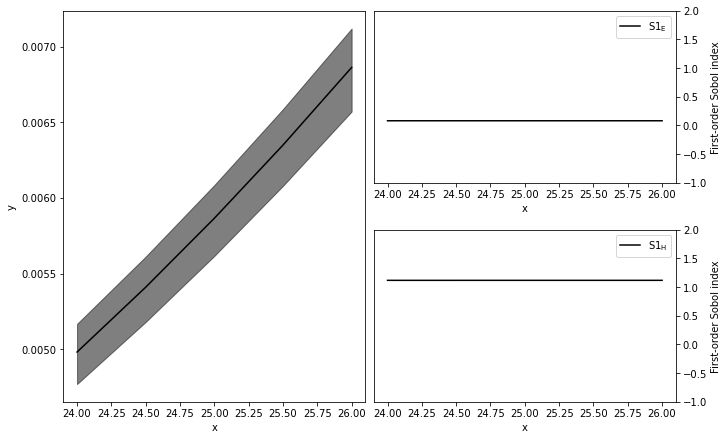

In [9]:
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 2)
ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1])

for i, ax in enumerate([ax1, ax2]):
    ax.plot(x, S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(problem["names"][i]),
            color='black')
    ax.set_xlabel("x")
    ax.set_ylabel("First-order Sobol index")

    ax.set_ylim(-1, 2)

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    ax.legend(loc='upper right')

ax0.plot(x, np.mean(y, axis=0), label="Mean", color='black')

# in percent
prediction_interval = 95

ax0.fill_between(x,
                 np.percentile(y, 50 - prediction_interval/2., axis=0),
                 np.percentile(y, 50 + prediction_interval/2., axis=0),
                 alpha=0.5, color='black',
                 label=f"{prediction_interval} % prediction interval")

ax0.set_xlabel("x")
ax0.set_ylabel("y")


plt.show()

In [10]:

S1s = np.array([s['S1'] for s in sobol_indices])
S2s = np.array([s['S2'] for s in sobol_indices])
Sts = np.array([s['ST'] for s in sobol_indices])
print("First order indices")
print(S1s)
print("Second order indices")
print(S2s)
print("Total order indices")
print(Sts)

print("min:",min(map(min, y)))
print("max",max(map(max, y)))




First order indices
[[0.08208289 1.11858759]
 [0.0820737  1.11859678]
 [0.08206618 1.11860492]
 [0.0820591  1.11861214]
 [0.08205168 1.11862014]]
Second order indices
[[[        nan -0.04589341]
  [        nan         nan]]

 [[        nan -0.04588965]
  [        nan         nan]]

 [[        nan -0.04588756]
  [        nan         nan]]

 [[        nan -0.04588503]
  [        nan         nan]]

 [[        nan -0.04588294]
  [        nan         nan]]]
Total order indices
[[0.06039652 1.11316328]
 [0.06038926 1.11317269]
 [0.06038268 1.11318076]
 [0.06037661 1.11318974]
 [0.06037069 1.11319594]]
min: 0.004754887012543375
max 0.007136862738267958


# Example 3: Sensitivity analysis at a point

In [11]:
def parabola(x, a, b, c):
    return sin(a) + 100 * sin(b) ** 2 + c**4 * sin(a) + x - x
problem = {
    'num_vars': 3,
    'names': ['a', 'b', 'c'],
    'bounds': [[-3.14159265359,3.14159265359],[-3.14159265359,3.14159265359],[-3.14159265359,3.14159265359]]
}

# sample
param_values = saltelli.sample(problem, 2**15)

# evaluate
x = np.array([0])
y = np.array([parabola(x, *params) for params in param_values])

# analyse
sobol_indices = [sobol.analyze(problem, Y) for Y in y.T]
S1s = np.array([s['S1'] for s in sobol_indices])

Sensitivity indices and maximum and minimum outputs

In [12]:

S1s = np.array([s['S1'] for s in sobol_indices])
S2s = np.array([s['S2'] for s in sobol_indices])
Sts = np.array([s['ST'] for s in sobol_indices])
print("First order indices")
print(S1s)
print("Second order indices")
print(S2s)
print("Total order indices")
print(Sts)

print("min:",min(map(min, y)))
print("max",max(map(max, y)))




First order indices
[[ 1.16095388e-01  6.95548647e-01 -6.14231311e-04]]
Second order indices
[[[           nan 3.74783246e-06 1.88352356e-01]
  [           nan            nan 3.26279736e-06]
  [           nan            nan            nan]]]
Total order indices
[[0.30411956 0.69555245 0.18773846]]
min: -96.98259836111642
max 198.20700614027368


In [ ]:
First order indices:
[[ 1.16095388e-01  6.95548647e-01 -6.14231311e-04]]
Second order indices:
[[[           nan 3.74783246e-06 1.88352356e-01]
  [           nan            nan 3.26279736e-06]
  [           nan            nan            nan]]]
Total order indices
[[0.30411956 0.69555245 0.18773846]]
min: -96.98259836111642
max 198.20700614027368


# Example 4: Sensitivity analysis at a point

In [ ]:
problem = {
    'num_vars': 3,
    'names': ['E','H','L'],
    'bounds': [[100000-1000, 100000+1000],[.98,1.02],[.8,1.2]]
}
param_values = saltelli.sample(problem, 2**6)
x = np.array([25])
y = np.array([prob2(x, *params) for params in param_values])

In [17]:
sobol_indices = [sobol.analyze(problem, Y) for Y in y.T]

Sensitivity indices and maximum and minimum outputs

In [18]:

S1s = np.array([s['S1'] for s in sobol_indices])
S2s = np.array([s['S2'] for s in sobol_indices])
Sts = np.array([s['ST'] for s in sobol_indices])
print("First order indices")
print(S1s)
print("Second order indices")
print(S2s)
print("Total order indices")
print(Sts)

print("min:",min(map(min, y)))
print("max",max(map(max, y)))
print(sobol_indices)




First order indices
[[-8.03338142e-04  2.29969530e-03  9.99441595e-01]]
Second order indices
[[[        nan  0.00154324  0.00272012]
  [        nan         nan -0.000201  ]
  [        nan         nan         nan]]]
Total order indices
[[3.23450526e-04 1.44548123e-03 1.00181391e+00]]
min: 1.5229183323782916e-08
max 5.206859695915568e-08
[{'S1': array([-8.03338142e-04,  2.29969530e-03,  9.99441595e-01]), 'S1_conf': array([0.00576365, 0.01306389, 0.32306892]), 'ST': array([3.23450526e-04, 1.44548123e-03, 1.00181391e+00]), 'ST_conf': array([1.27761475e-04, 6.47014172e-04, 2.54141380e-01]), 'S2': array([[        nan,  0.00154324,  0.00272012],
       [        nan,         nan, -0.000201  ],
       [        nan,         nan,         nan]]), 'S2_conf': array([[       nan, 0.00924001, 0.01064888],
       [       nan,        nan, 0.02494913],
       [       nan,        nan,        nan]])}]


In [ ]:
First order indices:
[[-8.03338142e-04  2.29969530e-03  9.99441595e-01]]
Second order indices:
[[[        nan  0.00154324  0.00272012]
  [        nan         nan -0.000201  ]
  [        nan         nan         nan]]]
Total order indices:
[[3.23450526e-04 1.44548123e-03 1.00181391e+00]]
min: 1.5229183323782916e-08
max: 5.206859695915568e-08
[{'S1': array([-8.03338142e-04,  2.29969530e-03,  9.99441595e-01]), 
'S1_conf': array([0.00576365, 0.01306389, 0.32306892]), 
'ST': array([3.23450526e-04, 1.44548123e-03, 1.00181391e+00]), 
'ST_conf': array([1.27761475e-04, 6.47014172e-04, 2.54141380e-01]),
'S2': array([[        nan,  0.00154324,  0.00272012],
       [        nan,         nan, -0.000201  ],
       [        nan,         nan,         nan]]), 'S2_conf': array([[       nan, 0.00924001, 0.01064888],
       [       nan,        nan, 0.02494913],
       [       nan,        nan,        nan]])}]